# Analyze A/B Test Results 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#Conclusions)



<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, We will be working to understand the results of an A/B test run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. The goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)



In [3]:
#read in the `ab_data.csv` data. Store it in `df`
df = pd.read_csv('ab_data.csv')

#check first 5 rows
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# info about df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


find the number of rows in the dataset.

In [5]:
df.shape

(294478, 5)

The number of unique users in the dataset.

In [6]:
df["user_id"].nunique()

290584

The proportion of users converted.

In [7]:
df["converted"].mean()

0.11965919355605512

The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [8]:
notmatched1 = df[(df.group == "treatment") & (df.landing_page != "new_page")].shape[0]
notmatched1 

1965

The number of times when the "group" is `control` but "landing_page" is not a `old_page`.

In [9]:
notmatched2 = df[(df.group == "control") & (df.landing_page != "old_page")].shape[0]
notmatched2

1928

The number of times the `new_page` and `treatment` don't line up.

In [10]:
# adding the previous calculations
total_notmatched = notmatched1 + notmatched2
total_notmatched

3893

check the missing values

In [11]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

no missing values found

 
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


In [12]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
# Drop the rows of the mismatching between treatment "group" & "landing_page" 
# which we havedcalculated previously,  the value of "3893",


df2 = (df.drop(df[(df.group =="treatment") & (df.landing_page != "new_page")].index)).drop(df[(df.group =="control") & (df.landing_page != "old_page")].index)



In [13]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [14]:
# check df2
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


How many unique **user_id**s are in **df2**?

In [15]:
df2["user_id"].nunique()

290584

There is one **user_id** repeated in **df2**

In [16]:
# check the repeated user_id
df2 [df2.duplicated( ["user_id"] , keep = False)]["user_id"]

1899    773192
2893    773192
Name: user_id, dtype: int64

 Display the rows for the duplicate **user_id** 

In [17]:
df2.loc[df["user_id"] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [18]:
# Remove one of the rows with a duplicate user_id..
df2 = df2.drop_duplicates("user_id")
# Check again if the row with a duplicate user_id is deleted or not
df2.loc[df["user_id"] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


In [19]:
# check dataframe shape
df2.shape

(290584, 5)

The probability of an individual converting regardless of the page they receive (overall "converted" success rate in the population), we can call it call it $p_{population}$.

In [20]:
df2['converted'].mean()

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [21]:
# conversion rate for control group
control_converted_mean = df2.query('group =="control"')["converted"].mean()
control_converted_mean

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [22]:
# conversion rate for treatment group
treatment_converted_mean = df2.query('group =="treatment"')["converted"].mean()
treatment_converted_mean

0.11880806551510564

In [23]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treatment_converted_mean - control_converted_mean
obs_diff

-0.0015782389853555567

What is the probability that an individual received the new page?

In [24]:
len(df2[df2["landing_page"] == "new_page"])/df2.shape[0]

0.5000619442226688

check the duration of the test

In [25]:
# convert timestamp column datatype into Datetime
df2["timestamp"] = df2['timestamp'].astype('datetime64[ns]')
# compute the duration
df2.timestamp.max() - df2.timestamp.min()

Timedelta('21 days 23:59:49.081927')

>**Based on the results above**
> - Given that an individual was in the control group, the conversion rate is 12.04% " old page "
> - Given that an individual was in the treatment group, the conversion rate is 11.88% "new page"
> - The duration for this experiment was 21 days
> - The old page is doing slightly better, however the duration of the experiment was not large enough also  but we don't know if the change resistence was a major factor or no, we need to wait for more time for the old users to get used to the new page. 

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  

For now, consider we need to make the decision just based on all the data provided.  

> Recall that we just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page  

If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be our null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

**Hypothesis**

$$H_0: P_{new} - P_{old} \leq 0$$ 

$$H_1: P_{new} - P_{old} > 0$$

$$\alpha = 0.05$$

 Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



The **conversion rate** for $p_{new}$ under the null hypothesis

In [26]:
# p_new under the null
p_new = df2["converted"].mean()
p_new

0.11959708724499628

The **conversion rate** for $p_{old}$ under the null hypothesis

In [27]:
# p_old under the null
p_old =  df2["converted"].mean()
p_old

0.11959708724499628

The number of individuals in the treatment group (The treatment group users are shown the new page.) <br>
$n_{new}$

In [28]:
# number of individuals  in the treatment group "received the new page"
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

The number of individuals in the control group <br>
$n_{old}$

In [29]:
# number of individuals  in the control group "received the old page"
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

**Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [30]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice(2, size = n_new, p = (1-p_new, p_new))

**Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [31]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice(2, size = n_old, p = (1-p_old, p_old))

The difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from above. 

In [33]:
# converted probability of the new page
p_new  = new_page_converted.mean()

# converted" probability of the old page
p_old =  old_page_converted.mean()

# the difference between them 
diff = p_new - p_old

print("p_new =", p_new ,
      "\n""p_old  = ", p_old ,
      "\n" "differenc_in_means (p_new - p_old) =  ",diff )

p_new = 0.119977978116 
p_old  =  0.120283051337 
differenc_in_means (p_new - p_old) =   -0.00030507322172



**Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [121]:
# Sampling distribution 
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice(2, size = n_new, p = (1-p_new, p_new))
    old_page_converted = np.random.choice(2, size = n_old, p = (1-p_old, p_old))
    p_diff = new_page_converted.mean() - old_page_converted.mean() 
    p_diffs.append(p_diff)

**Histogram**<br> 
Plot a histogram of the **p_diffs**

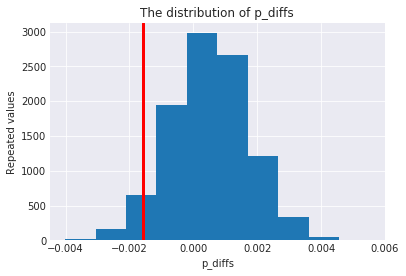

In [122]:
# Plot the distribution of p_diffs
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)
plt.title('The distribution of p_diffs')
plt.xlabel("p_diffs");
plt.ylabel("Repeated values");
plt.axvline(x=obs_diff, color="r", linewidth=3);


The proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data

In [123]:
# Calculate the p value under the null
# The probabilty of observing our statistic or more extreme in favor of the alternative given that the null hypothesis is true.
p_val = (p_diffs > obs_diff).mean()
p_val

0.95699999999999996

>**Based on what we just computed**
> - The actual difference between new page and old page is negative, suggesting old page may be slightly better.
> - However we have computed the p-value, and it is much greater than  Type I error "$\alpha = 0.05$ ".
> - Therefore we fail to reject the null hypothesis, and we should keep and keep the old page.



**Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

we will calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [34]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('group == "control" & converted == 1').shape[0]

# number of conversions with the new_page
convert_new = df2.query('group == "treatment" and converted == 1').shape[0]

# number of individuals who were shown the old_page
n_old = df2.query('group == "control"').shape[0]

# number of individuals who received new_page
n_new = df2.query('group == "treatment"').shape[0]

#show results
print ("convert_old = {}\nconvert_new = {}\nn_old = {}\nn_new = {}".format(convert_old, convert_new, n_old, n_new))

convert_old = 17489
convert_new = 17264
n_old = 145274
n_new = 145310


use sm.stats.proportions_ztest() to compute your test statistic and p-value

In [35]:
#compute the test statistic and p-value 
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new][::-1], [n_old, n_new][::-1], alternative='larger')

#show results
print("z_score = {} \np_value = {}".format (z_score, p_value) )

z_score = -1.3109241984234394 
p_value = 0.9050583127590245


**Based on what we just computed** 
> - The z-score and p-value confirm what we have computed before, that our p-value is very large 
> - Therefore we fail to reject the null hypothesis, and we should keep the old page.

<a id='regression'></a>
### Part III - A regression approach


In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 


> Since The dependent variable is a binary variable (converted vs not converted). we will use a logistic regression.

The goal is to use **statsmodels** library to fit the regression model we specified above to see if there is a significant difference in conversion based on the page-type a customer receives. However, first we need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [36]:
# Add intercept column to the data frame
df2["intercept"] = 1

# Add ab_page colum as a dummy variable colum
df2["ab_page"] = pd.get_dummies(df2["group"])["treatment"]

# Display the first 5 rows from our df
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


 Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [37]:
# Create the model
model = sm.Logit(df2["converted"], df2[['intercept','ab_page']])

# Fit the model
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


The summary of the model is below

In [38]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-12-13 17:29 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

>**Based on what we just computed.**


> - In A/B Test (Part II) before, we were concernced about which page had a higher conversion than the the other, 
so we have performed a one-sided test:

$$H_0: P_{new} - P_{old} \leq 0$$ 

$$H_1: P_{new} - P_{old} > 0$$

> - But in logistic regression (Part III), we were concerned about whether there is a difference in the conversion rates between the two pages, 
so we have performed a two-sided test, 
therfore the null and alternetive hypothesis are:

$$H_0: P_{new} - P_{old} = 0$$ 

$$H_1: P_{new} - P_{old} \neq 0$$

> - The p-value associated with ab_page is 0.1899, which is much greater than  Type I error "$\alpha = 0.05$ "
> - Therefore we fail to reject the null hypothesis, and we should keep the old page.

**- It is a good idea to consider other factors to add into your regression model, for example: location, age and prior academic background, as it may impact our test results and leads to make more accurate decisions.**  <br><br>
**- However, there are  disadvantages to adding additional terms into your regression model, as we can't account all the influencing factors, and the model will get more complex, and it will cost more time and money to collect the data** 


**Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. Read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. The resulting dataframe will be called`df_merged`. 
2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 


In [39]:
# Read the countries.csv
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [40]:
# create a new dataframe called "df_merged" by joining "df2" dataframe with "countries_df" dataframe
df_merged = df2.set_index("user_id").join(df_countries.set_index("user_id"), how = "inner")

# view the first 5 rows
df_merged.head()     

,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [41]:
# check unique values in country columns
df_merged["country"].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [42]:
# Create the necessary dummy variables
df_merged = df_merged.join(pd.get_dummies(df_merged["country"]))

#view first 5 rows
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
user_id,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [44]:
# Add the country dummy variables to your base model
log_model = sm.Logit(df_merged["converted"], df_merged[["intercept", "ab_page", "US", "UK"]])
log_model_results = log_model.fit()
log_model_results.summary2()


Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-12-13 17:34 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
==================================================================

"""

>- There is no significant effect on the convertion based on the country
>- the p-value, and it is much greater than Type I error " 𝛼=0.05  ".
>- Therefore we fail to reject the null hypothesis, and we should keep and keep the old page.


**Fit the model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


In [46]:
# Fit the model
# add interactive dummy variables

# Add new columns US_ab_page and UK_ab_page by multiplying the country colum with the ab_page
df_merged["US_ab_page"] = df_merged["US"] * df_merged["ab_page"]
df_merged["UK_ab_page"] = df_merged["UK"] * df_merged["ab_page"]

# Create the model
model = sm.Logit(df_merged["converted"], df_merged[['intercept','ab_page', 'US', 'UK', 'US_ab_page', 'UK_ab_page']])

# Fit the model
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [47]:
# Display the summary statistics
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-12-13 17:42 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US_ab_page     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
UK_ab_page     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

In [49]:
np.exp(results.params)

intercept     0.134794
ab_page       0.934776
US            1.017682
UK            1.011854
US_ab_page    1.048001
UK_ab_page    1.081428
dtype: float64

In [50]:
1/_

intercept     7.418713
ab_page       1.069775
US            0.982625
UK            0.988285
US_ab_page    0.954198
UK_ab_page    0.924703
dtype: float64

>- A user from the US treatment group is 1.048001 times more likely to convert than a CA user, holding all other variables constants.
>- A user from the UK treatment group is 1.081428 times more likely to convert than a CA user, holding all other variables constants.
>- After including both page and country into the model we still find that there is no significant effect on the convertion based on the country.
>- All p-values, are much greater than Type I error " 𝛼=0.05  ".
>- Therefore we fail to reject the null hypothesis again, and we should keep the old page.


<a id='Conclusions'></a>
## Conclusions
In conclusion
- The old page is doing slightly better. And the test between the old_page and the new_page does not seem to have much effect on the conversion.
- We recommend using the old_page.
- However the duration of the experiment was not large enough, and we need to take into consideration if the change resistence was a major factor or not, we need to wait for more time for the old users to get used to the new page.

In [51]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0